<a href="https://colab.research.google.com/github/varuntulsian2001/density_estimation_diffusion_models/blob/master/5.colab_EMNIST_conditional.diffusion_model.large.bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process

In [1]:
!pip install --upgrade -q clu einops dm-haiku optax flax
!pip install --upgrade -q dm-tree graphviz imageio[ffmpeg]

     |████████████████████████████████| 92 kB 593 kB/s 
     |████████████████████████████████| 41 kB 568 kB/s 
     |████████████████████████████████| 352 kB 14.0 MB/s 
     |████████████████████████████████| 154 kB 78.6 MB/s 
     |████████████████████████████████| 189 kB 73.9 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 237 kB 73.1 MB/s 
     |████████████████████████████████| 8.3 MB 67.1 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
     |████████████████████████████████| 47 kB 384 kB/s 
     |████████████████████████████████| 26.9 MB 1.1 MB/s 


In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os
from flax import jax_utils

colab = True

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

In [3]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_new_model = True
cont=False
model_name = 'emnist_fixed_with_cond.jax_version.BatchNorm'

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/"
  dataset_path = "/home/varun/tensorflow_datasets/"
else:
  data_paths = F"/content/gdrive/MyDrive/EMNIST/data/"
  model_paths = F"/content/gdrive/MyDrive/EMNIST/model/"
  gifs_dir = F"/content/gdrive/MyDrive/EMNIST/gifs/"
  dataset_path = F"/content/gdrive/MyDrive/EMNIST/dataset/"

In [5]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.1)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [7]:
# Train model
timesteps = 250
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)
key = jax.random.PRNGKey(42)

# how to add noise to the data
@jax.jit
def get_noisy(rng, batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    # need to generate new keys everytime
    _, noise_key = jax.random.split(rng)
    noise_at_t = jax.random.normal(noise_key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = jnp.subtract(batch, noise*sd[timestep])/(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7f4dca1d4f40>],
 [<matplotlib.lines.Line2D at 0x7f4dca200070>])

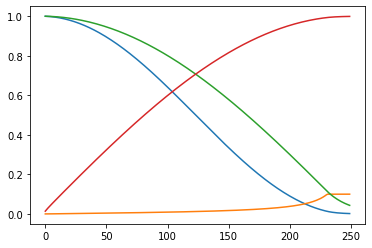

In [8]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_)), plt.plot(sd)

In [9]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm
from clu import deterministic_data

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image.

  Arguments:
    arr : array-like The image data. The shape can be one of MxN (luminance),
      MxNx3 (RGB) or MxNx4 (RGBA).
    vmin : scalar, optional lower value.
    vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
      image by fixing the values that map to the colormap color limits. If
      either *vmin* or *vmax* is None, that limit is determined from the *arr*
      min/max value.
    cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
      registered colormap name. The colormap maps scalar data to colors. It is
      ignored for RGB(A) data.
        Defaults to :rc:`image.cmap` ('viridis').
    origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
      of the array is in the upper
        left or lower left corner of the axes.  Defaults to :rc:`image.origin`
          ('upper').

  Returns:
    A uint8 image array.
  """
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = io.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    array: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = array.shape
  assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(math.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  array = array[:cut]
  array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
  array = np.moveaxis(array, axis + 2, axis + 1)
  array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
  return array

def zoom(im, k, axes=(0, 1)):
  for ax in axes:
    im = np.repeat(im, k, ax)
  return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
  if normalize:
    im = im - im.min()
    im = im / im.max()
  return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

# replicate = flax.jax_utils.replicate
# unreplicate = flax.jax_utils.unreplicate

In [10]:
#@title data

dataset_builder = tfds.builder('emnist', data_dir=dataset_path)
dataset_builder.download_and_prepare()

train_split = tfds.split_for_jax_process('train+train', drop_remainder=True)

def preprocess_fn(example):
  image = tf.cast(example['image'], 'float32')
  image = tf.transpose(image, (1, 0, 2,))
  image = image / 255.0
  return (image, example["label"] + 1)

batch_size = 4 * 128 if colab else 64
train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=train_split,
    rng=jax.random.PRNGKey(0),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=None,
    preprocess_fn=lambda x: preprocess_fn(x),
    shuffle=True)

def create_input_iter(ds):
  def _prepare(xs):
    def _f(x):
      x = x._numpy()
      return x
    return jax.tree_util.tree_map(_f, xs)
  it = map(_prepare, ds)
  it = jax_utils.prefetch_to_device(it, 2)
  return it

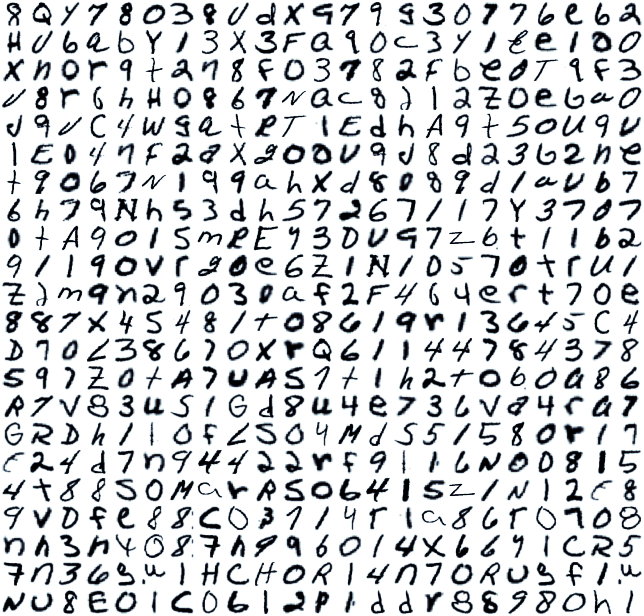

In [11]:
out = next(create_input_iter(train_ds))
rawarrview(reshape_image_batch(out[0][0].squeeze()), cmap='bone_r')

In [12]:
# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
@jax.jit
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.mean(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

# Recommended: this can be jit'd and it should result in faster training time 
partial(jax.jit,  static_argnums=(4,))
def compute_loss(params: hk.Params, state: hk.State, batch: Batch, is_energy_method: bool=False, is_training=False) -> Tuple[jnp.ndarray, Tuple[jnp.ndarray, hk.State]]:
  """Compute the loss of the network, including L2."""
  x, label, timestep, noise = batch
  # not capturing state as it is not needed; it should be internally updated and maintaing by haiku and doesn't need gradient updates 
  pred_data, state = net.apply(params, state, x, timestep, label, is_training)
  
  def error_func():
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_, (loss_, state)

@jax.jit
def update(
    params: hk.Params,
    state: hk.State,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False) -> Tuple[jnp.ndarray, hk.Params, optax.OptState, hk.State]:
  """Compute gradients and update the weights"""
  grads, (loss_value, state)= jax.grad(compute_loss, has_aux=True)(params, state, batch, is_energy_method, is_training=True)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state, state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def unnormalize(images):
  return images*255.
  

In [13]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
# batch_size=512
# train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [14]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(create_input_iter(train_ds))[0][0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(key, einops.repeat(image, 'h w c -> b h w c', b=timesteps//5), jnp.arange(1, timesteps, 5))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir+'diffusion.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

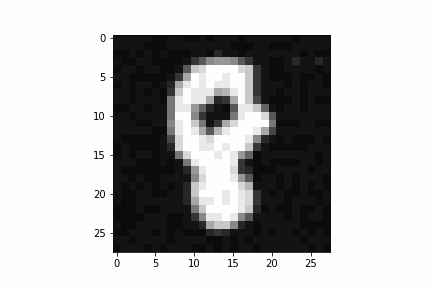

In [15]:
with open(gifs_dir + 'diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [16]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return self.conv(x)
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return self.conv(x)
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    # using batch norm instead of layernorm as the batch sizes are large
    # orig: self.norm = hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.conv1 = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timestep_embeddings=None, is_training=False):
    h = self.proj(x)
    h = self.norm(h, is_training)
    if timestep_embeddings is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timestep_embeddings)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.silu(self.norm1(self.conv1(self.silu(h)), is_training))
    return self.out_conv(x) + h

In [17]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=48, kernel_shape = (5,5), padding='SAME', with_bias=False)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.block1 = Block(output_channels=48, kernel_size=3, padding=1)
    self.downsample1 = Downsample(96)
    self.block2 = Block(output_channels=96, kernel_size=3, padding=1)
    self.downsample2 = Downsample(192)
    self.middle_block = Block(output_channels=192, kernel_size=3, padding=1)
    self.upsample1 = Upsample(96)
    self.block3 = Block(output_channels=96, kernel_size=3, padding=1)
    self.upsample2 = Upsample(48)
    self.block4 = Block(output_channels=48, kernel_size=3, padding=1)
    self.conv1 = hk.Conv2D(output_channels=48, kernel_shape = (3,3), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.conv2 = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
    
    self.time_mlp = hk.Sequential([
      hk.Linear(256),
      jax.nn.gelu,
      hk.Linear(256),
    ])
    # conditional vectors encoding
    self.embedding_vectors = hk.Embed(10+26+26+1, 63)
    self.timestep_embeddings = TimeEmbeddings(96)
      
  def __call__(self, x, timesteps, cond=None, is_training=False):
    cond_embedding = None
    conditioning = None
    if timesteps is not None:
      timestep_embeddings = self.timestep_embeddings(timesteps)
      conditioning = timestep_embeddings
    if cond is not None:
      label_embeddings = self.embedding_vectors(cond)
      conditioning = jnp.concatenate([label_embeddings, conditioning], axis=1)
    if conditioning is not None:  
      cond_embedding = self.time_mlp(conditioning)
    h = self.silu(self.norm(self.init_conv(x), is_training))
    xx = jnp.copy(h)
    b1 = self.block1(h, cond_embedding, is_training)
    h = self.downsample1(b1)
    b2 = self.block2(h, cond_embedding, is_training)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, cond_embedding, is_training))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), cond_embedding, is_training)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), cond_embedding, is_training)
    h = self.conv2(self.silu(self.norm1(self.conv1(jnp.concatenate((xx, b4), axis=3)), is_training)))
    return h

In [18]:
def save(ckpt_dir: str, params, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "wb") as f:
     pickle.dump(state, f)
      
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "wb") as f:
     pickle.dump(params, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "rb") as f:
    state = pickle.load(f)
 
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "rb") as f:
    params = pickle.load(f)
    
  return params, state

def test_model_save():
  save('saved/saved_models/', avg_params, state, 'emnist_model')
  avg_params, state = restore('saved/saved_models/', 'emnist_model')

In [19]:
import graphviz

def f(x, timesteps, label, is_training):
  unet = UNet()
  return unet(x, timesteps, label, is_training)

f_t = hk.transform_with_state(f)
net = hk.without_apply_rng(f_t)

image, label = next(create_input_iter(train_ds)) #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, batch_size)

_, rng = jax.random.split(key)

if cont and os.path.exists(osp.join(model_paths, model_name + '_state.pkl')):
  avg_params, state = restore(model_paths, model_name)
  params = deepcopy(avg_params, state)
else:
  params, state = net.init(rng, image[0][0:batch_size], timesteps_, label[0][0:batch_size], is_training=True)

opt = optax.adam(1e-3)

avg_params = deepcopy(params)
opt_state = opt.init(params)



---




### Training

In [20]:
def show_predicted_image(noisy_image, params, timestep, state, label=None):
  print('time step for image: ', timestep, ' label: ', label)
  timestep = jnp.array([timestep])
  pred_noise, _ = net.apply(params, state, noisy_image, timestep, label, is_training=False)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

In [21]:
b, l = image[0], label[0] # next(create_input_iter(train_ds))[0]

unique_key = jax.random.fold_in(key, jnp.sum(b))
_, *subkeys = jax.random.split(unique_key, timesteps)

time step for image:  249  label:  [35]


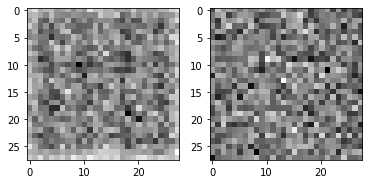

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

[195.71265]


In [22]:
def test_loss_fn():
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(subkeys[i-1], b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, state, [data_noisy_temp[0:1], l[0:1], tt, 
                                                          noise_temp[0:1]], is_energy_method=False, is_training=False)[0]))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp, _ = net.apply(avg_params, state, data_noisy_temp[0:1], tt, l[0:1], is_training=False)
    reconstructed = recover_original(data_noisy_temp[0:1], tt, pp)
    model_huber_loss.append(huber_loss(reconstructed[0:1], data_noisy_temp[0:1]))
    
  print(show_predicted_image(data_noisy_temp[0:1], avg_params, i, state, l[0:1]))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

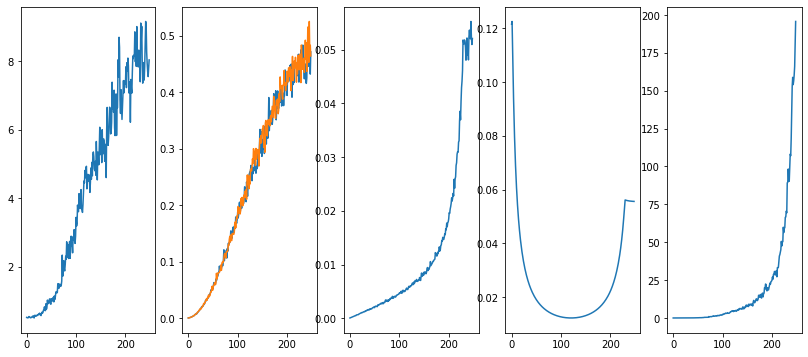

In [26]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [27]:
from copy import deepcopy
import pickle
import sys

batches_iter = 10000
one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
train = create_input_iter(train_ds) 
data_in_batch_, label_ = next(train)
data_in_batch_ = data_in_batch_[0]
label_ = label_[0]
data_noisy_temp_, noise_temp_ = get_noisy(key, data_in_batch_, one_timestep)

def train_model(opt_state, params, avg_params, state, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization   

    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        # generating sub keys for timesteps
        unique_key = jax.random.fold_in(key, batch_size)
        
        # same subkey being used for noise sampling, as it doesn't matter :)
        _, *timestep_subkeys = jax.random.split(unique_key, batches_iter+1)
        
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = data_in_batch[0]
            label = label[0]
            idx = (jax.random.uniform(key=timestep_subkeys[iteration], shape=(batch_size, 1)) * (timesteps-1)).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(timestep_subkeys[iteration], data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state, state = update(params, state, opt_state, [data_noisy, label, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("batch loss value: ", loss_value)
            
            if iteration % 2 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                loss_temp, _ = jax.device_get(compute_loss(avg_params, state, [data_noisy_temp_, label_, one_timestep, noise_temp_], energy_method, is_training=False))
                losses.append(loss_temp)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration: {iteration} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, state, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
            
                if iteration % 100 == 0:
                    print(f"iteration: {iteration} loss: {loss_temp:>7f}")
                    # sample a random number
                    r_ = (jax.random.uniform(timestep_subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(data_noisy_temp_[r_: r_+1], avg_params, one_timestep[r_], state, label_[r_: r_+1])

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params, state = restore(model_paths, model_name)
        params = deepcopy(avg_params)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params, state

batch loss value:  0.49126583
saving iteration: 0 loss: 3.254519
iteration: 0 loss: 3.254519
time step for image:  169  label:  [10]


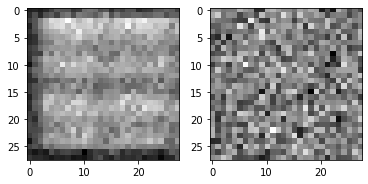

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 2 loss: 0.305936
saving iteration: 8 loss: 0.274960
batch loss value:  0.11519345
saving iteration: 12 loss: 0.195388
saving iteration: 16 loss: 0.144726
saving iteration: 18 loss: 0.122052
batch loss value:  0.083980784
saving iteration: 20 loss: 0.104625
saving iteration: 22 loss: 0.094616
saving iteration: 24 loss: 0.088913
saving iteration: 26 loss: 0.085036
batch loss value:  0.07421042
saving iteration: 30 loss: 0.082539
saving iteration: 32 loss: 0.082006
saving iteration: 34 loss: 0.079423
saving iteration: 36 loss: 0.078053
saving iteration: 38 loss: 0.078023
batch loss value:  0.061722618
saving iteration: 40 loss: 0.074361
saving iteration: 44 loss: 0.068828
saving iteration: 48 loss: 0.067190
batch loss value:  0.05639593
saving iteration: 52 loss: 0.066294
saving iteration: 54 loss: 0.061372
saving iteration: 58 loss: 0.058892
batch loss value:  0.05319696
saving iteration: 62 loss: 0.057939
saving iteration: 64 loss: 0.057714
saving iteration: 66 loss: 0

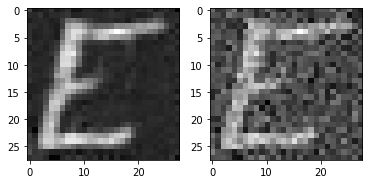

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 106 loss: 0.041144
batch loss value:  0.038197495
saving iteration: 110 loss: 0.040549
saving iteration: 114 loss: 0.039896
batch loss value:  0.033677675
saving iteration: 122 loss: 0.037421
batch loss value:  0.03505574
saving iteration: 132 loss: 0.036827
saving iteration: 136 loss: 0.034871
batch loss value:  0.029522676
saving iteration: 148 loss: 0.033221
batch loss value:  0.029330958
saving iteration: 156 loss: 0.032614
saving iteration: 158 loss: 0.031925
batch loss value:  0.032922022
saving iteration: 166 loss: 0.030565
saving iteration: 168 loss: 0.030117
batch loss value:  0.030548979
saving iteration: 170 loss: 0.029650
batch loss value:  0.02680663
saving iteration: 182 loss: 0.029143
saving iteration: 184 loss: 0.029062
saving iteration: 186 loss: 0.028709
batch loss value:  0.028158166
saving iteration: 196 loss: 0.028087
batch loss value:  0.02916604
iteration: 200 loss: 0.031958
time step for image:  193  label:  [25]


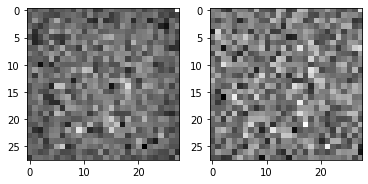

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 206 loss: 0.027115
batch loss value:  0.024533926
batch loss value:  0.02675251
saving iteration: 222 loss: 0.027001
saving iteration: 224 loss: 0.026968
batch loss value:  0.026798055
saving iteration: 236 loss: 0.026781
batch loss value:  0.023049474
saving iteration: 248 loss: 0.026546
batch loss value:  0.024691757
saving iteration: 250 loss: 0.025965
batch loss value:  0.02233195
saving iteration: 260 loss: 0.025929
saving iteration: 264 loss: 0.025643
saving iteration: 266 loss: 0.025190
batch loss value:  0.022417933
saving iteration: 274 loss: 0.024747
batch loss value:  0.02705863
batch loss value:  0.023668235
batch loss value:  0.023019012
iteration: 300 loss: 0.025375
time step for image:  206  label:  [8]


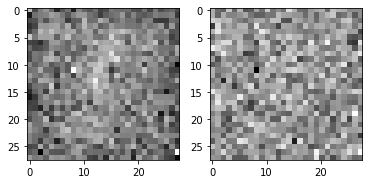

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.027488548
batch loss value:  0.023578513
saving iteration: 320 loss: 0.024076
batch loss value:  0.025165634
batch loss value:  0.022797097
saving iteration: 340 loss: 0.023887
saving iteration: 346 loss: 0.023550
batch loss value:  0.02154459
saving iteration: 356 loss: 0.023062
saving iteration: 358 loss: 0.022990
batch loss value:  0.021443851
saving iteration: 362 loss: 0.022918
saving iteration: 366 loss: 0.022798
batch loss value:  0.02316894
saving iteration: 378 loss: 0.022640
batch loss value:  0.022327159
batch loss value:  0.021446558
saving iteration: 394 loss: 0.022314
batch loss value:  0.019269813
iteration: 400 loss: 0.022652
time step for image:  104  label:  [6]


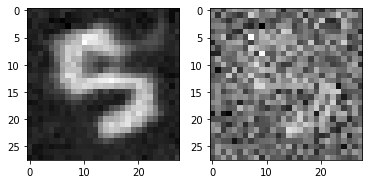

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.021146454
saving iteration: 410 loss: 0.021992
batch loss value:  0.021086559
saving iteration: 420 loss: 0.021752
saving iteration: 424 loss: 0.021647
saving iteration: 428 loss: 0.021609
batch loss value:  0.023902785
saving iteration: 430 loss: 0.021468
batch loss value:  0.020283649
batch loss value:  0.0203032
batch loss value:  0.01983969
saving iteration: 464 loss: 0.021241
batch loss value:  0.021291187
batch loss value:  0.019226424
saving iteration: 484 loss: 0.021145
batch loss value:  0.019153152
batch loss value:  0.02018113
iteration: 500 loss: 0.021327
time step for image:  88  label:  [10]


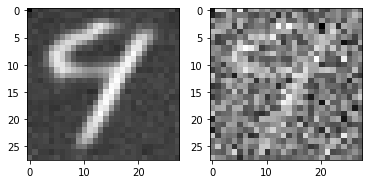

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 502 loss: 0.020983
batch loss value:  0.022241395
saving iteration: 510 loss: 0.020851
saving iteration: 512 loss: 0.020756
batch loss value:  0.01901805
saving iteration: 520 loss: 0.020641
saving iteration: 522 loss: 0.020472
batch loss value:  0.020219095
batch loss value:  0.021593962
batch loss value:  0.019943237
batch loss value:  0.019760376
saving iteration: 566 loss: 0.020433
saving iteration: 568 loss: 0.020354
batch loss value:  0.01855261
saving iteration: 578 loss: 0.020221
batch loss value:  0.021142496
saving iteration: 588 loss: 0.020047
batch loss value:  0.018671189
batch loss value:  0.017390154
iteration: 600 loss: 0.020360
time step for image:  239  label:  [15]


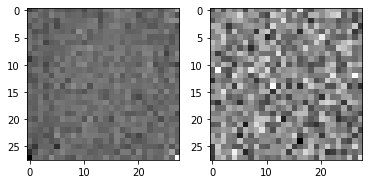

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.018405955
batch loss value:  0.019096397
batch loss value:  0.017779332
batch loss value:  0.018652488
saving iteration: 642 loss: 0.020000
saving iteration: 644 loss: 0.019770
batch loss value:  0.018963402
batch loss value:  0.018533755
saving iteration: 668 loss: 0.019589
batch loss value:  0.019528227
batch loss value:  0.018780146
batch loss value:  0.018404275
saving iteration: 696 loss: 0.019582
batch loss value:  0.01864469
iteration: 700 loss: 0.019874
time step for image:  211  label:  [40]


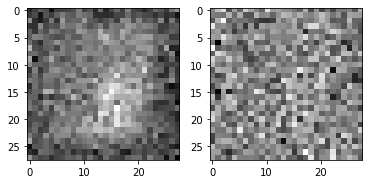

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 708 loss: 0.019380
batch loss value:  0.020314697
batch loss value:  0.019218761
batch loss value:  0.019171938
batch loss value:  0.019597167
batch loss value:  0.01981805
batch loss value:  0.019030228
batch loss value:  0.017349347
batch loss value:  0.018661592
saving iteration: 782 loss: 0.019259
saving iteration: 784 loss: 0.019019
batch loss value:  0.017857254
saving iteration: 798 loss: 0.018818
batch loss value:  0.017003737
iteration: 800 loss: 0.019322
time step for image:  92  label:  [7]


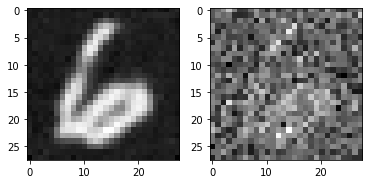

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.018080093
batch loss value:  0.018770037
batch loss value:  0.018952027
batch loss value:  0.016201703
batch loss value:  0.018585414
batch loss value:  0.018159844
batch loss value:  0.018359313
batch loss value:  0.01757675
saving iteration: 884 loss: 0.018798
saving iteration: 886 loss: 0.018731
batch loss value:  0.018312018
batch loss value:  0.017675433
iteration: 900 loss: 0.019468
time step for image:  126  label:  [3]


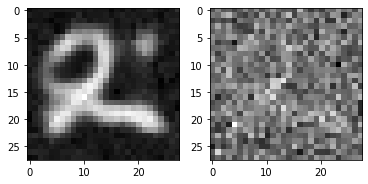

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.01818264
batch loss value:  0.019897599
batch loss value:  0.016566385
saving iteration: 936 loss: 0.018723
saving iteration: 938 loss: 0.018649
batch loss value:  0.018948846
batch loss value:  0.01821531
batch loss value:  0.01891096
saving iteration: 960 loss: 0.018519
batch loss value:  0.017054062
saving iteration: 974 loss: 0.018495
saving iteration: 976 loss: 0.018448
batch loss value:  0.016510095
saving iteration: 982 loss: 0.018227
batch loss value:  0.01877727
batch loss value:  0.017890431
iteration: 1000 loss: 0.019645
time step for image:  58  label:  [15]


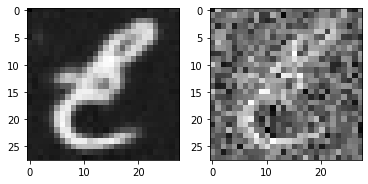

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.017221993
batch loss value:  0.01630425
batch loss value:  0.016513987
batch loss value:  0.016607294
batch loss value:  0.017956078
batch loss value:  0.016666014
saving iteration: 1062 loss: 0.018213
batch loss value:  0.017221378
batch loss value:  0.018597193
saving iteration: 1080 loss: 0.018197
saving iteration: 1088 loss: 0.018139
batch loss value:  0.016129639
batch loss value:  0.0165762
saving iteration: 1100 loss: 0.018099
iteration: 1100 loss: 0.018099
time step for image:  59  label:  [2]


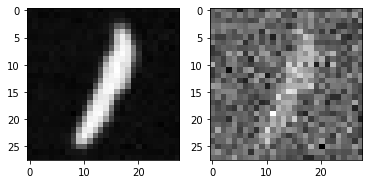

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 1102 loss: 0.018096
saving iteration: 1104 loss: 0.017981
batch loss value:  0.017827507
batch loss value:  0.016704895
batch loss value:  0.017744336
batch loss value:  0.016997272
batch loss value:  0.016386192
batch loss value:  0.017568298
batch loss value:  0.017270649
saving iteration: 1172 loss: 0.017896
batch loss value:  0.017247582
batch loss value:  0.017913254
batch loss value:  0.017650455
iteration: 1200 loss: 0.018189
time step for image:  158  label:  [3]


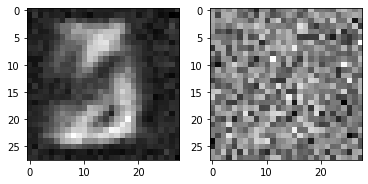

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.017648097
batch loss value:  0.017692983
batch loss value:  0.016180297
batch loss value:  0.017511435
batch loss value:  0.01586321
saving iteration: 1256 loss: 0.017721
batch loss value:  0.016518835
batch loss value:  0.015796758
batch loss value:  0.016414773
batch loss value:  0.016592793
batch loss value:  0.01768791
iteration: 1300 loss: 0.019174
time step for image:  71  label:  [37]


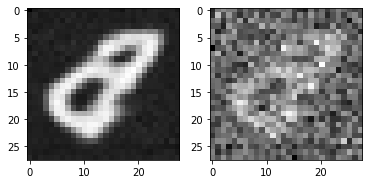

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.016185928
batch loss value:  0.015031022
batch loss value:  0.018481702
batch loss value:  0.017396506
saving iteration: 1342 loss: 0.017702
batch loss value:  0.016771449
batch loss value:  0.015631506
saving iteration: 1360 loss: 0.017663
saving iteration: 1364 loss: 0.017557
saving iteration: 1366 loss: 0.017525
batch loss value:  0.017499283
saving iteration: 1376 loss: 0.017384
batch loss value:  0.016164912
batch loss value:  0.015451791
batch loss value:  0.01579969
iteration: 1400 loss: 0.018255
time step for image:  179  label:  [1]


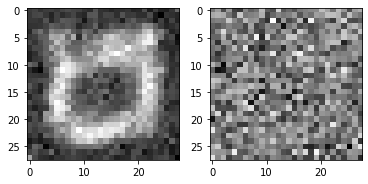

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.018222274
batch loss value:  0.015465249
batch loss value:  0.014493339
batch loss value:  0.016355403
saving iteration: 1448 loss: 0.017207
batch loss value:  0.01843683
batch loss value:  0.017205313
batch loss value:  0.018119562
batch loss value:  0.015945751
batch loss value:  0.015616617
batch loss value:  0.016372697
iteration: 1500 loss: 0.017630
time step for image:  52  label:  [4]


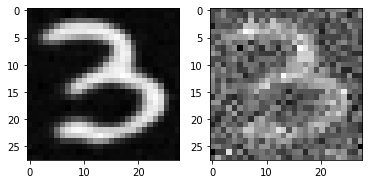

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 1502 loss: 0.017099
batch loss value:  0.017053012
batch loss value:  0.014930505
batch loss value:  0.017204931
batch loss value:  0.016813569
batch loss value:  0.016755082
batch loss value:  0.016301598
saving iteration: 1566 loss: 0.017021
batch loss value:  0.016688462
batch loss value:  0.0165169
batch loss value:  0.019501023
batch loss value:  0.015890386
iteration: 1600 loss: 0.017301
time step for image:  172  label:  [9]


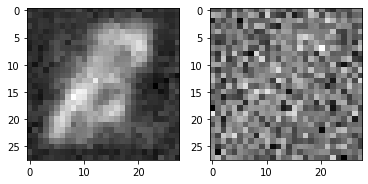

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.016251305
batch loss value:  0.015980797
batch loss value:  0.016729252
batch loss value:  0.014687339
batch loss value:  0.01651389
batch loss value:  0.014310833
batch loss value:  0.014806142
batch loss value:  0.017291069
batch loss value:  0.016293094
batch loss value:  0.016117446
iteration: 1700 loss: 0.017226
time step for image:  244  label:  [44]


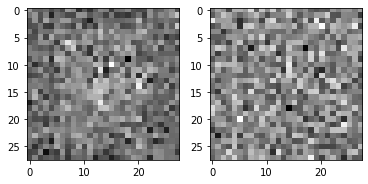

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015061249
saving iteration: 1712 loss: 0.017020
batch loss value:  0.016832823
batch loss value:  0.016368538
batch loss value:  0.01606403
batch loss value:  0.016646001
saving iteration: 1754 loss: 0.016793
batch loss value:  0.015428573
batch loss value:  0.016436217
batch loss value:  0.016939295
batch loss value:  0.016761541
saving iteration: 1796 loss: 0.016772
batch loss value:  0.016156677
iteration: 1800 loss: 0.017038
time step for image:  116  label:  [11]


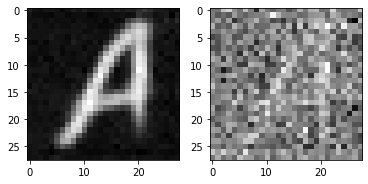

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015054728
batch loss value:  0.015364525
batch loss value:  0.016740248
batch loss value:  0.015017381
batch loss value:  0.015384292
batch loss value:  0.016069056
batch loss value:  0.01583886
batch loss value:  0.016065627
batch loss value:  0.014927203
batch loss value:  0.016166488
iteration: 1900 loss: 0.016792
time step for image:  25  label:  [38]


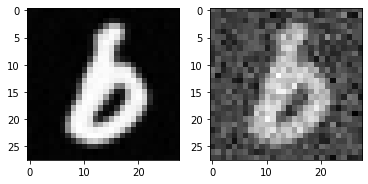

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0153315505
batch loss value:  0.01488831
saving iteration: 1922 loss: 0.016684
batch loss value:  0.015054364
batch loss value:  0.016255563
saving iteration: 1942 loss: 0.016619
batch loss value:  0.016016133
batch loss value:  0.0164507
batch loss value:  0.015001357
batch loss value:  0.01643442
batch loss value:  0.015263919
batch loss value:  0.015468345
iteration: 2000 loss: 0.016904
time step for image:  158  label:  [3]


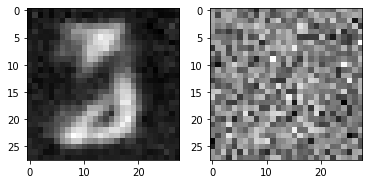

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015875919
batch loss value:  0.017375724
batch loss value:  0.016917331
batch loss value:  0.01663554
batch loss value:  0.015171872
batch loss value:  0.017413046
batch loss value:  0.015737955
batch loss value:  0.015472073
batch loss value:  0.016486444
batch loss value:  0.016834317
iteration: 2100 loss: 0.016765
time step for image:  215  label:  [38]


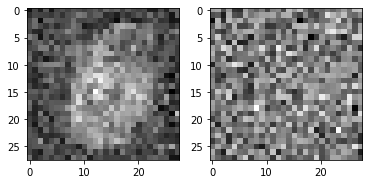

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 2104 loss: 0.016603
batch loss value:  0.015305645
saving iteration: 2114 loss: 0.016365
batch loss value:  0.015092177
batch loss value:  0.015562974
batch loss value:  0.015196979
saving iteration: 2146 loss: 0.016308
batch loss value:  0.0148880435
batch loss value:  0.015301954
batch loss value:  0.015892548
batch loss value:  0.014945796
batch loss value:  0.01644601
batch loss value:  0.0139806345
iteration: 2200 loss: 0.016985
time step for image:  142  label:  [4]


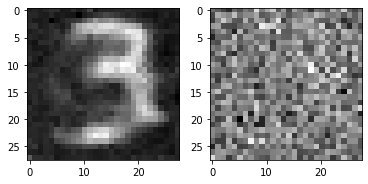

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014233514
batch loss value:  0.014361976
batch loss value:  0.014244759
batch loss value:  0.016341805
batch loss value:  0.015643649
batch loss value:  0.014486807
batch loss value:  0.015385098
batch loss value:  0.016390951
batch loss value:  0.015709044
batch loss value:  0.015652
iteration: 2300 loss: 0.016892
time step for image:  80  label:  [43]


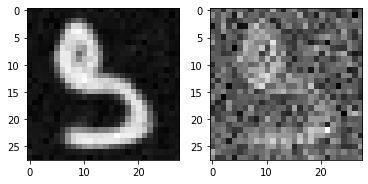

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014922703
batch loss value:  0.015159765
batch loss value:  0.014774451
batch loss value:  0.015916938
batch loss value:  0.0151928095
batch loss value:  0.014827389
saving iteration: 2362 loss: 0.016269
saving iteration: 2364 loss: 0.016192
batch loss value:  0.016551357
saving iteration: 2378 loss: 0.016115
batch loss value:  0.0146689005
batch loss value:  0.015438928
batch loss value:  0.016496126
iteration: 2400 loss: 0.016344
time step for image:  123  label:  [4]


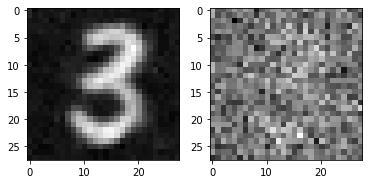

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015022437
batch loss value:  0.014555636
batch loss value:  0.0147293005
batch loss value:  0.016121099
batch loss value:  0.014602913
batch loss value:  0.014497045
batch loss value:  0.014758165
saving iteration: 2472 loss: 0.016115
saving iteration: 2478 loss: 0.016017
batch loss value:  0.0149827665
batch loss value:  0.015170479
batch loss value:  0.015423302
iteration: 2500 loss: 0.016391
time step for image:  140  label:  [25]


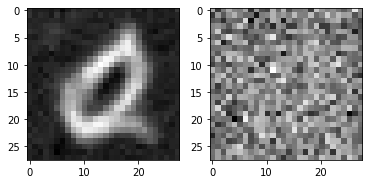

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015133799
batch loss value:  0.015401255
batch loss value:  0.014099222
batch loss value:  0.016024988
batch loss value:  0.01553532
batch loss value:  0.014657384
batch loss value:  0.014143126
batch loss value:  0.015521295
batch loss value:  0.01601
batch loss value:  0.014690384
iteration: 2600 loss: 0.017060
time step for image:  3  label:  [37]


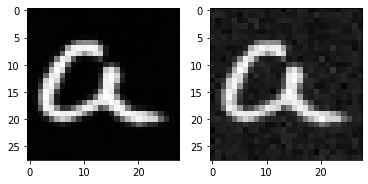

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 2604 loss: 0.015958
batch loss value:  0.016232736
batch loss value:  0.014930471
batch loss value:  0.014628157
batch loss value:  0.015619021
batch loss value:  0.015756538
saving iteration: 2656 loss: 0.015943
batch loss value:  0.014478372
batch loss value:  0.014005701
batch loss value:  0.015038055
saving iteration: 2686 loss: 0.015937
batch loss value:  0.014632056
batch loss value:  0.01432593
iteration: 2700 loss: 0.016225
time step for image:  96  label:  [1]


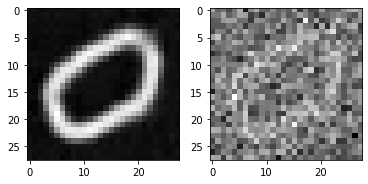

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014840828
batch loss value:  0.015973257
batch loss value:  0.015522126
saving iteration: 2732 loss: 0.015778
batch loss value:  0.014453158
batch loss value:  0.015347429
batch loss value:  0.013774636
batch loss value:  0.01499648
batch loss value:  0.015533884
batch loss value:  0.015469623
batch loss value:  0.014326867
iteration: 2800 loss: 0.015966
time step for image:  15  label:  [22]


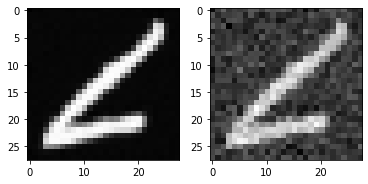

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015783306
batch loss value:  0.015059291
batch loss value:  0.015446808
batch loss value:  0.015324618
batch loss value:  0.01467335
batch loss value:  0.015048234
batch loss value:  0.014099722
batch loss value:  0.015032234
batch loss value:  0.01458396
batch loss value:  0.013963986
iteration: 2900 loss: 0.016075
time step for image:  181  label:  [15]


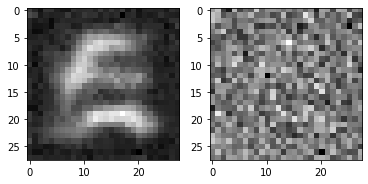

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014492629
batch loss value:  0.014301551
batch loss value:  0.014604916
batch loss value:  0.014935277
saving iteration: 2940 loss: 0.015705
batch loss value:  0.014393763
batch loss value:  0.014759484
batch loss value:  0.013478834
saving iteration: 2972 loss: 0.015644
batch loss value:  0.015874827
batch loss value:  0.015228501
batch loss value:  0.014269891
iteration: 3000 loss: 0.016340
time step for image:  203  label:  [1]


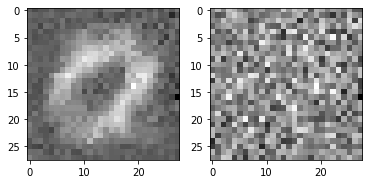

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014533382
batch loss value:  0.014408718
batch loss value:  0.014280888
batch loss value:  0.014725588
batch loss value:  0.014287578
batch loss value:  0.014819607
batch loss value:  0.015982885
batch loss value:  0.014345791
batch loss value:  0.013939157
batch loss value:  0.014771021
iteration: 3100 loss: 0.016059
time step for image:  163  label:  [30]


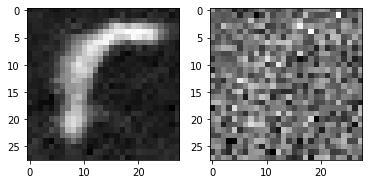

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013366936
batch loss value:  0.015092082
batch loss value:  0.014911754
saving iteration: 3130 loss: 0.015564
batch loss value:  0.014279726
batch loss value:  0.013958888
batch loss value:  0.015621353
batch loss value:  0.013977898
batch loss value:  0.0136154005
batch loss value:  0.014590723
batch loss value:  0.01364323
iteration: 3200 loss: 0.015884
time step for image:  178  label:  [40]


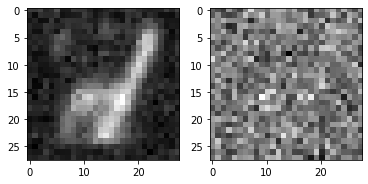

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014661876
saving iteration: 3216 loss: 0.015488
batch loss value:  0.013997392
batch loss value:  0.015364806
batch loss value:  0.014357835
batch loss value:  0.014393647
batch loss value:  0.014198192
batch loss value:  0.0136112245
batch loss value:  0.013461189
batch loss value:  0.016194962
batch loss value:  0.014846339
iteration: 3300 loss: 0.016734
time step for image:  62  label:  [2]


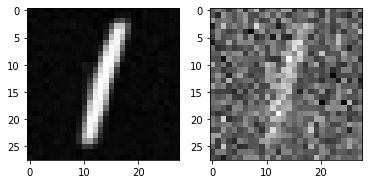

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0148599185
saving iteration: 3318 loss: 0.015420
batch loss value:  0.013478471
batch loss value:  0.015217397
batch loss value:  0.014660437
batch loss value:  0.013562502
batch loss value:  0.015942436
batch loss value:  0.014977074
batch loss value:  0.013390913
batch loss value:  0.014408857
batch loss value:  0.0149909835
iteration: 3400 loss: 0.016014
time step for image:  50  label:  [8]


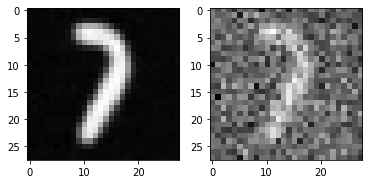

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014321648
batch loss value:  0.01444233
batch loss value:  0.0146713
batch loss value:  0.0149519835
batch loss value:  0.015311228
batch loss value:  0.015396865
batch loss value:  0.013699343
batch loss value:  0.014444785
batch loss value:  0.0153451525
saving iteration: 3498 loss: 0.015378
batch loss value:  0.014317121
iteration: 3500 loss: 0.016101
time step for image:  25  label:  [38]


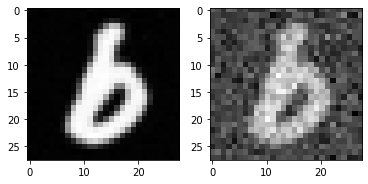

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 3504 loss: 0.015323
batch loss value:  0.013810965
batch loss value:  0.013468648
batch loss value:  0.014392177
batch loss value:  0.014715786
batch loss value:  0.015035415
batch loss value:  0.0155397225
batch loss value:  0.014134319
saving iteration: 3576 loss: 0.015283
batch loss value:  0.016029458
batch loss value:  0.014316309
batch loss value:  0.01362416
iteration: 3600 loss: 0.015630
time step for image:  156  label:  [28]


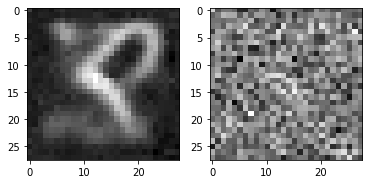

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013891245
batch loss value:  0.014643047
batch loss value:  0.0134374155
batch loss value:  0.015420747
saving iteration: 3640 loss: 0.015271
batch loss value:  0.014274769
batch loss value:  0.014916883
batch loss value:  0.014434234
saving iteration: 3672 loss: 0.015225
batch loss value:  0.014807204
batch loss value:  0.014150862
batch loss value:  0.014593879
iteration: 3700 loss: 0.016419
time step for image:  29  label:  [32]


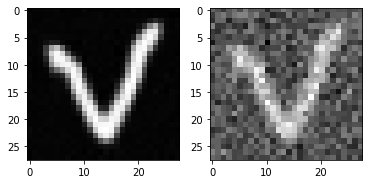

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0141711235
batch loss value:  0.015081607
batch loss value:  0.013105265
batch loss value:  0.014362164
batch loss value:  0.013581957
batch loss value:  0.013561854
batch loss value:  0.013473682
batch loss value:  0.015285074
batch loss value:  0.013831202
batch loss value:  0.014776675
iteration: 3800 loss: 0.016885
time step for image:  24  label:  [1]


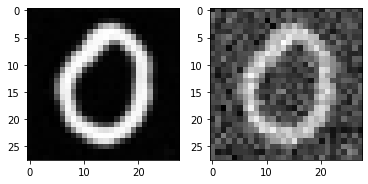

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014454128
saving iteration: 3818 loss: 0.015211
batch loss value:  0.013888247
batch loss value:  0.014615342
batch loss value:  0.014207101
batch loss value:  0.012832369
batch loss value:  0.014064598
batch loss value:  0.013768419
batch loss value:  0.01376899
batch loss value:  0.014558387
batch loss value:  0.014478534
iteration: 3900 loss: 0.015712
time step for image:  144  label:  [36]


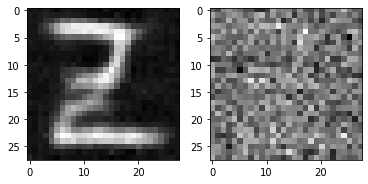

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 3902 loss: 0.015199
batch loss value:  0.014900553
batch loss value:  0.014015921
batch loss value:  0.014073381
batch loss value:  0.013814318
batch loss value:  0.0154249035
batch loss value:  0.014751205
batch loss value:  0.015291427
saving iteration: 3974 loss: 0.015149
saving iteration: 3976 loss: 0.015144
batch loss value:  0.013486173
batch loss value:  0.013370954
batch loss value:  0.013849206
iteration: 4000 loss: 0.015813
time step for image:  113  label:  [19]


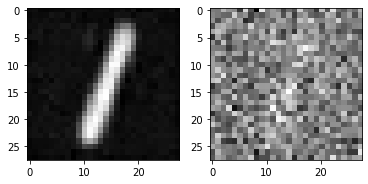

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015254285
batch loss value:  0.013675841
saving iteration: 4028 loss: 0.015090
batch loss value:  0.013065995
batch loss value:  0.014100578
batch loss value:  0.014940467
batch loss value:  0.0135954255
batch loss value:  0.013995975
batch loss value:  0.014928025
batch loss value:  0.014530182
batch loss value:  0.014398851
iteration: 4100 loss: 0.015385
time step for image:  237  label:  [8]


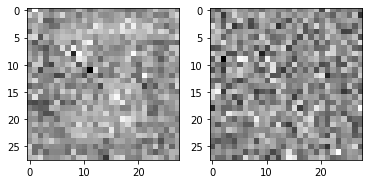

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014528653
saving iteration: 4112 loss: 0.015052
batch loss value:  0.013751909
batch loss value:  0.012830913
batch loss value:  0.013778224
batch loss value:  0.013911684
saving iteration: 4154 loss: 0.015027
saving iteration: 4158 loss: 0.015023
batch loss value:  0.013575581
batch loss value:  0.01401186
batch loss value:  0.0123833725
batch loss value:  0.013841007
batch loss value:  0.013473783
iteration: 4200 loss: 0.015169
time step for image:  200  label:  [8]


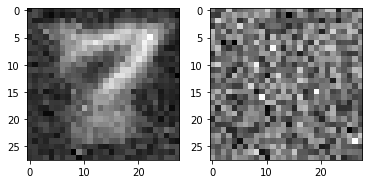

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014992179
saving iteration: 4214 loss: 0.014993
batch loss value:  0.014531257
batch loss value:  0.01413838
saving iteration: 4234 loss: 0.014985
batch loss value:  0.013392576
batch loss value:  0.013409457
batch loss value:  0.0138098495
batch loss value:  0.014792357
batch loss value:  0.014112145
batch loss value:  0.013616519
batch loss value:  0.014381461
iteration: 4300 loss: 0.015096
time step for image:  101  label:  [18]


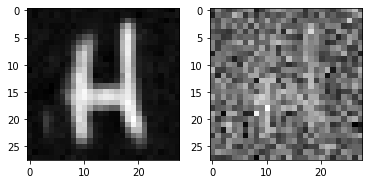

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.015545089
batch loss value:  0.014343748
batch loss value:  0.014836272
batch loss value:  0.014381239
batch loss value:  0.0142166
batch loss value:  0.014135264
saving iteration: 4364 loss: 0.014977
batch loss value:  0.014700896
batch loss value:  0.015551219
batch loss value:  0.013751358
batch loss value:  0.013395902
iteration: 4400 loss: 0.015522
time step for image:  58  label:  [54]


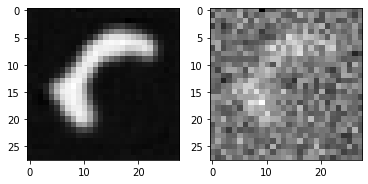

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013247233
batch loss value:  0.013017964
batch loss value:  0.014087499
batch loss value:  0.014190709
batch loss value:  0.013931399
saving iteration: 4452 loss: 0.014884
batch loss value:  0.014784623
batch loss value:  0.015279874
batch loss value:  0.015111532
batch loss value:  0.015142348
batch loss value:  0.013458936
iteration: 4500 loss: 0.015883
time step for image:  238  label:  [48]


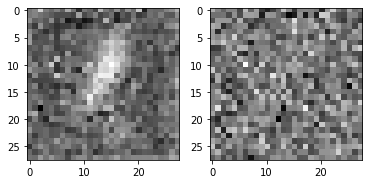

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014605563
batch loss value:  0.012427608
batch loss value:  0.0143077895
batch loss value:  0.01398492
saving iteration: 4548 loss: 0.014873
batch loss value:  0.014872795
batch loss value:  0.013324706
batch loss value:  0.013278478
batch loss value:  0.0139552
batch loss value:  0.013591211
batch loss value:  0.0144935455
iteration: 4600 loss: 0.015102
time step for image:  16  label:  [1]


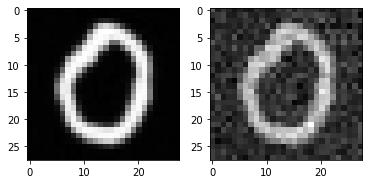

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 4608 loss: 0.014828
batch loss value:  0.012567455
saving iteration: 4610 loss: 0.014826
saving iteration: 4612 loss: 0.014740
batch loss value:  0.013444141
batch loss value:  0.014067239
batch loss value:  0.014276153
batch loss value:  0.013904207
batch loss value:  0.01361593
batch loss value:  0.014446551
batch loss value:  0.015150975
batch loss value:  0.0133503135
batch loss value:  0.01472529
iteration: 4700 loss: 0.014920
time step for image:  248  label:  [7]


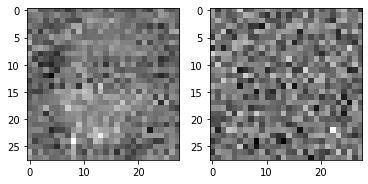

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013325006
batch loss value:  0.01404647
batch loss value:  0.013335653
batch loss value:  0.0132922325
batch loss value:  0.013726402
batch loss value:  0.0128811225
batch loss value:  0.013150975
batch loss value:  0.014510915
batch loss value:  0.014275645
batch loss value:  0.01469676
iteration: 4800 loss: 0.015447
time step for image:  57  label:  [44]


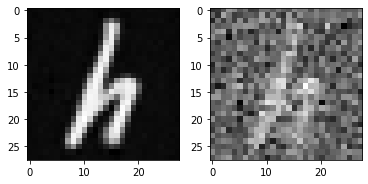

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.01362413
batch loss value:  0.014025422
batch loss value:  0.013646632
batch loss value:  0.014269326
batch loss value:  0.015054949
batch loss value:  0.014068793
saving iteration: 4864 loss: 0.014709
batch loss value:  0.013908059
batch loss value:  0.013033388
batch loss value:  0.0127174575
batch loss value:  0.0147439465
iteration: 4900 loss: 0.015017
time step for image:  232  label:  [5]


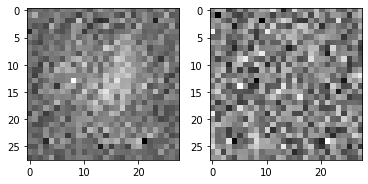

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013664274
batch loss value:  0.014878182
batch loss value:  0.013850723
batch loss value:  0.013629911
batch loss value:  0.0129983695
batch loss value:  0.013822861
batch loss value:  0.014046785
batch loss value:  0.01422962
batch loss value:  0.014964346
batch loss value:  0.012959769
iteration: 5000 loss: 0.015155
time step for image:  205  label:  [4]


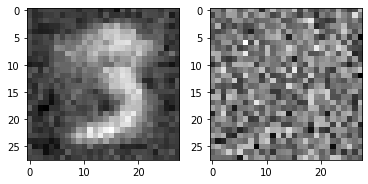

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 5008 loss: 0.014622
batch loss value:  0.012985496
batch loss value:  0.013264198
batch loss value:  0.013778022
batch loss value:  0.014257133
batch loss value:  0.015358604
batch loss value:  0.013261817
batch loss value:  0.013574021
batch loss value:  0.013443727
batch loss value:  0.01382157
batch loss value:  0.013860652
iteration: 5100 loss: 0.014758
time step for image:  127  label:  [8]


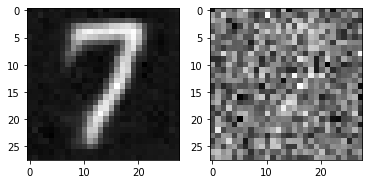

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0143311415
batch loss value:  0.012452723
batch loss value:  0.013287007
batch loss value:  0.013710264
batch loss value:  0.013235444
batch loss value:  0.013390288
batch loss value:  0.01453607
batch loss value:  0.012653593
batch loss value:  0.014368818
batch loss value:  0.013214634
iteration: 5200 loss: 0.015193
time step for image:  214  label:  [37]


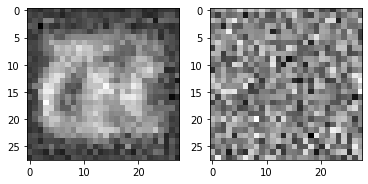

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014154498
batch loss value:  0.013902541
batch loss value:  0.013440067
batch loss value:  0.013303544
batch loss value:  0.01420144
batch loss value:  0.015298539
batch loss value:  0.012988402
batch loss value:  0.013247242
batch loss value:  0.014486738
batch loss value:  0.0126506835
iteration: 5300 loss: 0.015031
time step for image:  236  label:  [10]


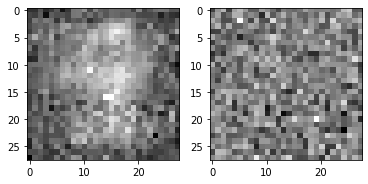

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013906784
saving iteration: 5314 loss: 0.014538
batch loss value:  0.0138813425
batch loss value:  0.013387601
batch loss value:  0.013295244
batch loss value:  0.0132500185
batch loss value:  0.0134069845
batch loss value:  0.015587515
batch loss value:  0.014717907
batch loss value:  0.013622763
batch loss value:  0.013576128
iteration: 5400 loss: 0.014863
time step for image:  130  label:  [50]


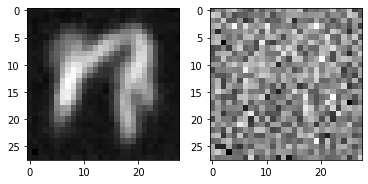

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013685377
batch loss value:  0.01363252
saving iteration: 5420 loss: 0.014450
batch loss value:  0.014805792
batch loss value:  0.013925978
batch loss value:  0.013201209
batch loss value:  0.014182939
batch loss value:  0.013259287
batch loss value:  0.013102315
batch loss value:  0.0140748415
batch loss value:  0.0145619605
iteration: 5500 loss: 0.014599
time step for image:  33  label:  [9]


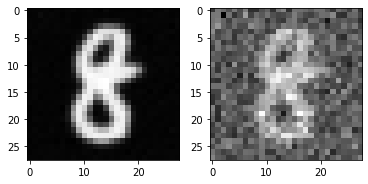

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012796337
batch loss value:  0.013376016
batch loss value:  0.012955448
batch loss value:  0.012616197
batch loss value:  0.014030588
batch loss value:  0.0131082665
batch loss value:  0.012917431
batch loss value:  0.014383687
batch loss value:  0.012647891
batch loss value:  0.01313226
iteration: 5600 loss: 0.014634
time step for image:  157  label:  [1]


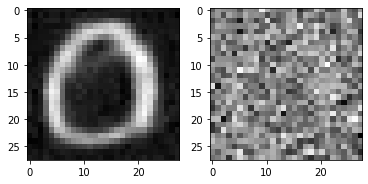

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012352988
batch loss value:  0.015584081
batch loss value:  0.013653537
batch loss value:  0.013898157
batch loss value:  0.013914188
saving iteration: 5658 loss: 0.014390
batch loss value:  0.013462108
batch loss value:  0.013480574
batch loss value:  0.012852157
batch loss value:  0.013052952
batch loss value:  0.014146979
iteration: 5700 loss: 0.014562
time step for image:  174  label:  [1]


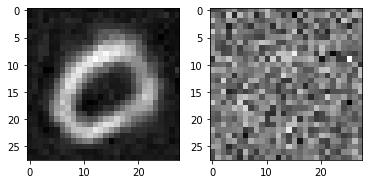

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0127508445
batch loss value:  0.01350287
batch loss value:  0.012453074
batch loss value:  0.014161007
batch loss value:  0.014188686
batch loss value:  0.013790995
saving iteration: 5768 loss: 0.014306
batch loss value:  0.012273097
batch loss value:  0.012702226
batch loss value:  0.012126934
batch loss value:  0.012921824
iteration: 5800 loss: 0.014428
time step for image:  105  label:  [9]


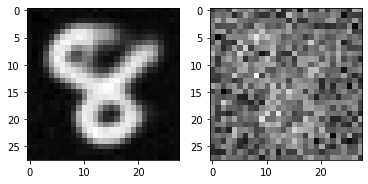

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013922462
batch loss value:  0.015173627
batch loss value:  0.013362349
batch loss value:  0.012899654
batch loss value:  0.015063386
batch loss value:  0.011739628
batch loss value:  0.013452629
batch loss value:  0.01352402
batch loss value:  0.012965193
batch loss value:  0.013687013
iteration: 5900 loss: 0.014514
time step for image:  182  label:  [9]


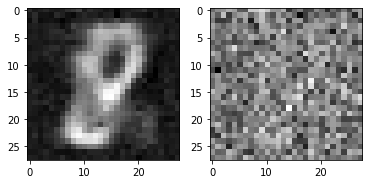

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012890569
batch loss value:  0.014124649
batch loss value:  0.01347205
batch loss value:  0.012390111
batch loss value:  0.013731512
batch loss value:  0.014389621
batch loss value:  0.013586935
batch loss value:  0.0130059915
batch loss value:  0.013217403
batch loss value:  0.013850991
iteration: 6000 loss: 0.014391
time step for image:  195  label:  [10]


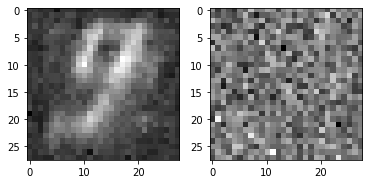

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014345108
batch loss value:  0.0125565855
batch loss value:  0.013005691
batch loss value:  0.014745633
saving iteration: 6042 loss: 0.014236
batch loss value:  0.012822196
batch loss value:  0.012605684
batch loss value:  0.013089342
batch loss value:  0.012461644
batch loss value:  0.013274181
batch loss value:  0.014399873
iteration: 6100 loss: 0.014463
time step for image:  218  label:  [28]


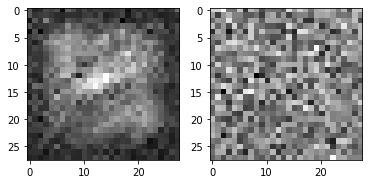

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012895627
batch loss value:  0.013158407
batch loss value:  0.0147461
batch loss value:  0.013048504
batch loss value:  0.014454503
batch loss value:  0.012844953
batch loss value:  0.012653621
batch loss value:  0.012876996
batch loss value:  0.012571808
batch loss value:  0.013391786
iteration: 6200 loss: 0.014520
time step for image:  114  label:  [2]


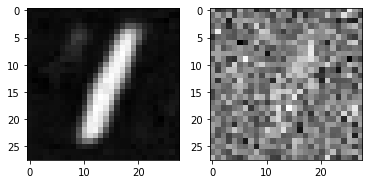

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012730695
saving iteration: 6218 loss: 0.014154
batch loss value:  0.013277249
batch loss value:  0.012430014
batch loss value:  0.012912017
batch loss value:  0.01339429
batch loss value:  0.01281878
batch loss value:  0.014294542
batch loss value:  0.013493035
batch loss value:  0.0138640255
batch loss value:  0.01321096
iteration: 6300 loss: 0.014826
time step for image:  58  label:  [15]


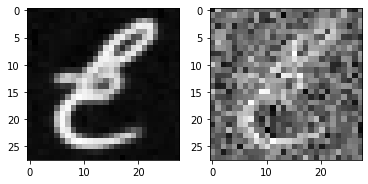

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013348823
batch loss value:  0.012868947
batch loss value:  0.013138449
batch loss value:  0.01335768
batch loss value:  0.013230756
batch loss value:  0.013396461
saving iteration: 6368 loss: 0.014152
batch loss value:  0.013222503
batch loss value:  0.012774728
batch loss value:  0.013331229
batch loss value:  0.013441922
iteration: 6400 loss: 0.014212
time step for image:  211  label:  [40]


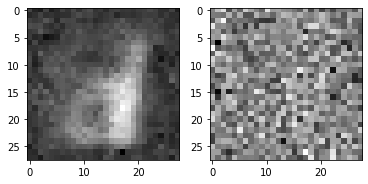

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 6402 loss: 0.014151
saving iteration: 6408 loss: 0.014143
batch loss value:  0.014338669
saving iteration: 6416 loss: 0.014050
batch loss value:  0.012667914
batch loss value:  0.012580173
batch loss value:  0.012021241
batch loss value:  0.013085326
batch loss value:  0.012194939
batch loss value:  0.013276384
batch loss value:  0.01328515
batch loss value:  0.013425931
batch loss value:  0.014163706
iteration: 6500 loss: 0.016512
time step for image:  98  label:  [7]


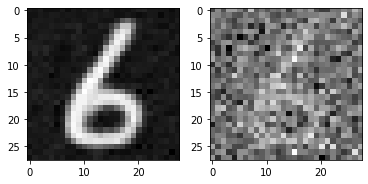

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012908295
batch loss value:  0.0139963925
batch loss value:  0.012540952
batch loss value:  0.013033016
batch loss value:  0.014103687
batch loss value:  0.013074473
batch loss value:  0.013533844
batch loss value:  0.013508361
batch loss value:  0.013741149
batch loss value:  0.014432861
iteration: 6600 loss: 0.014558
time step for image:  236  label:  [10]


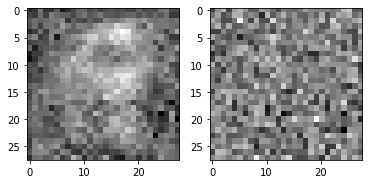

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.014976272
batch loss value:  0.013446994
batch loss value:  0.013030021
batch loss value:  0.012585336
batch loss value:  0.012469942
batch loss value:  0.012673649
batch loss value:  0.013107955
batch loss value:  0.014174234
batch loss value:  0.012603611
batch loss value:  0.012870971
iteration: 6700 loss: 0.014292
time step for image:  215  label:  [38]


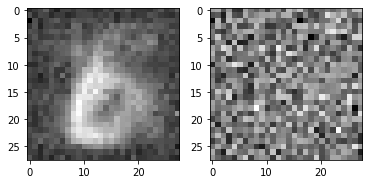

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.011848809
saving iteration: 6714 loss: 0.014021
batch loss value:  0.012556685
batch loss value:  0.0126969665
batch loss value:  0.013199794
batch loss value:  0.012527214
batch loss value:  0.01341228
batch loss value:  0.013440596
batch loss value:  0.011769991
saving iteration: 6788 loss: 0.013986
batch loss value:  0.014656333
batch loss value:  0.013107094
iteration: 6800 loss: 0.014176
time step for image:  107  label:  [41]


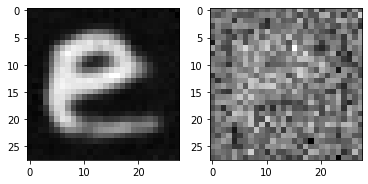

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013396325
batch loss value:  0.0139574325
batch loss value:  0.01338993
batch loss value:  0.013187408
batch loss value:  0.014036464
batch loss value:  0.014982354
batch loss value:  0.01364783
batch loss value:  0.013697496
batch loss value:  0.013937548
batch loss value:  0.013055743
iteration: 6900 loss: 0.014263
time step for image:  132  label:  [1]


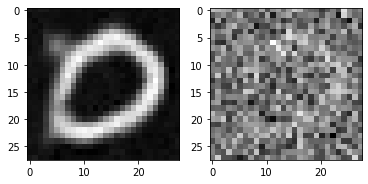

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013937155
batch loss value:  0.01318989
batch loss value:  0.013733824
batch loss value:  0.013366745
batch loss value:  0.012001656
saving iteration: 6958 loss: 0.013936
batch loss value:  0.011904072
batch loss value:  0.012414863
batch loss value:  0.013886093
batch loss value:  0.012514832
batch loss value:  0.01274753
iteration: 7000 loss: 0.014117
time step for image:  12  label:  [6]


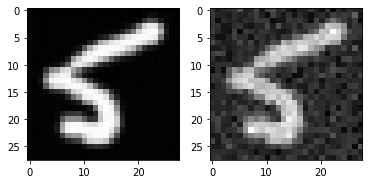

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012293301
batch loss value:  0.01426495
batch loss value:  0.013070531
saving iteration: 7032 loss: 0.013879
batch loss value:  0.013219422
batch loss value:  0.012528317
batch loss value:  0.013484975
batch loss value:  0.012966815
batch loss value:  0.012774335
batch loss value:  0.011707775
batch loss value:  0.013583762
iteration: 7100 loss: 0.014051
time step for image:  124  label:  [60]


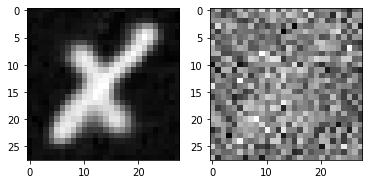

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013181044
batch loss value:  0.014157044
batch loss value:  0.012798327
batch loss value:  0.012854949
batch loss value:  0.013064999
batch loss value:  0.013060195
batch loss value:  0.012498346
batch loss value:  0.013100155
batch loss value:  0.013665873
batch loss value:  0.013528709
iteration: 7200 loss: 0.014214
time step for image:  184  label:  [9]


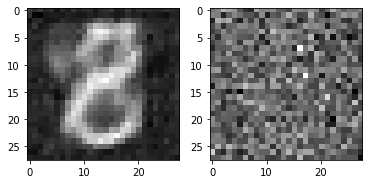

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0128925545
batch loss value:  0.012441844
batch loss value:  0.013740294
batch loss value:  0.012942236
batch loss value:  0.012778893
batch loss value:  0.01416448
batch loss value:  0.013302008
batch loss value:  0.0136814015
batch loss value:  0.013028735
batch loss value:  0.013268521
iteration: 7300 loss: 0.014128
time step for image:  4  label:  [2]


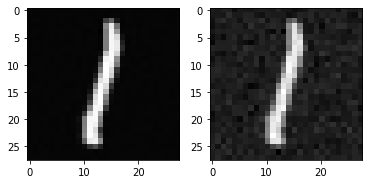

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 7304 loss: 0.013842
saving iteration: 7306 loss: 0.013834
batch loss value:  0.01324228
batch loss value:  0.012970367
batch loss value:  0.012574791
batch loss value:  0.01322264
saving iteration: 7342 loss: 0.013814
batch loss value:  0.01320125
batch loss value:  0.013009168
batch loss value:  0.013898419
batch loss value:  0.013064271
batch loss value:  0.012673907
batch loss value:  0.0146595
iteration: 7400 loss: 0.013969
time step for image:  183  label:  [8]


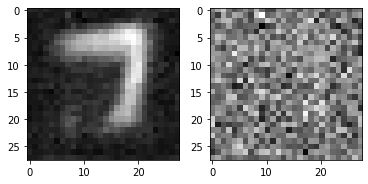

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012919648
batch loss value:  0.012493562
saving iteration: 7428 loss: 0.013793
batch loss value:  0.012898393
saving iteration: 7432 loss: 0.013781
batch loss value:  0.012214482
batch loss value:  0.012854038
batch loss value:  0.012760723
batch loss value:  0.012012909
batch loss value:  0.013034426
saving iteration: 7484 loss: 0.013684
batch loss value:  0.011735011
batch loss value:  0.012153322
iteration: 7500 loss: 0.013973
time step for image:  63  label:  [4]


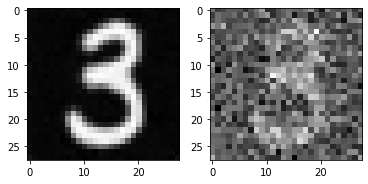

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013151079
batch loss value:  0.014169603
batch loss value:  0.013043793
batch loss value:  0.013336441
batch loss value:  0.013659971
batch loss value:  0.012571233
batch loss value:  0.012945121
batch loss value:  0.012637163
batch loss value:  0.013130441
batch loss value:  0.0141297
iteration: 7600 loss: 0.014221
time step for image:  131  label:  [1]


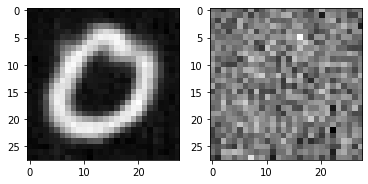

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013778529
batch loss value:  0.014403816
batch loss value:  0.01300309
batch loss value:  0.012252551
batch loss value:  0.011862387
batch loss value:  0.013452554
batch loss value:  0.012355604
batch loss value:  0.012980072
batch loss value:  0.012861237
batch loss value:  0.012154112
iteration: 7700 loss: 0.013977
time step for image:  165  label:  [56]


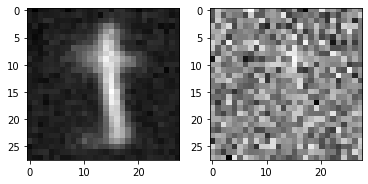

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012904961
saving iteration: 7718 loss: 0.013668
batch loss value:  0.013297732
batch loss value:  0.01279955
batch loss value:  0.012757616
batch loss value:  0.012130278
batch loss value:  0.011322793
saving iteration: 7768 loss: 0.013666
batch loss value:  0.012479216
saving iteration: 7770 loss: 0.013607
batch loss value:  0.013954439
batch loss value:  0.013905141
batch loss value:  0.01369407
iteration: 7800 loss: 0.013738
time step for image:  57  label:  [1]


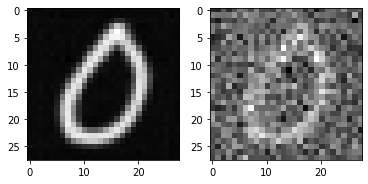

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013264584
batch loss value:  0.012686769
batch loss value:  0.011333454
batch loss value:  0.013520479
saving iteration: 7840 loss: 0.013561
batch loss value:  0.011836681
batch loss value:  0.013538963
batch loss value:  0.012911335
batch loss value:  0.013289711
batch loss value:  0.012606659
batch loss value:  0.013579022
iteration: 7900 loss: 0.013567
time step for image:  68  label:  [7]


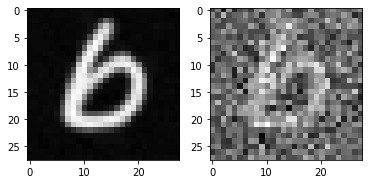

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012003264
batch loss value:  0.013182702
batch loss value:  0.01272426
batch loss value:  0.014485135
batch loss value:  0.012985949
batch loss value:  0.0124754235
batch loss value:  0.012732997
batch loss value:  0.013816589
batch loss value:  0.013513053
saving iteration: 7990 loss: 0.013552
batch loss value:  0.012210885
iteration: 8000 loss: 0.013819
time step for image:  217  label:  [61]


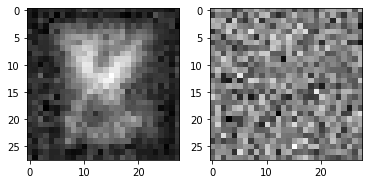

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012623781
batch loss value:  0.012462227
batch loss value:  0.013961288
batch loss value:  0.01413749
batch loss value:  0.012500068
batch loss value:  0.012787491
batch loss value:  0.012239529
batch loss value:  0.01243954
saving iteration: 8088 loss: 0.013508
batch loss value:  0.013219811
batch loss value:  0.012067031
iteration: 8100 loss: 0.013671
time step for image:  236  label:  [10]


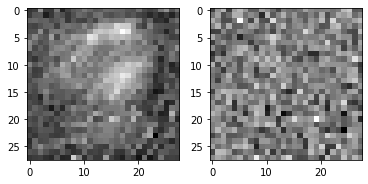

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012958137
batch loss value:  0.01350002
batch loss value:  0.012839923
batch loss value:  0.012836846
batch loss value:  0.012601764
batch loss value:  0.012491485
batch loss value:  0.01268916
batch loss value:  0.011816766
batch loss value:  0.0125804
batch loss value:  0.012548808
iteration: 8200 loss: 0.014038
time step for image:  17  label:  [54]


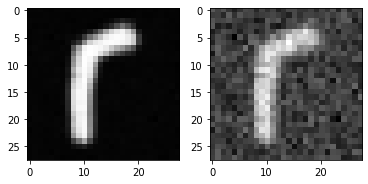

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012405308
batch loss value:  0.01340166
batch loss value:  0.012321259
batch loss value:  0.012792715
batch loss value:  0.0128374845
batch loss value:  0.012681523
saving iteration: 8262 loss: 0.013495
batch loss value:  0.012386935
batch loss value:  0.012681491
batch loss value:  0.013318242
batch loss value:  0.011825261
iteration: 8300 loss: 0.013729
time step for image:  122  label:  [5]


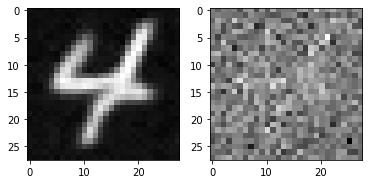

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012942564
batch loss value:  0.0138804875
batch loss value:  0.012303968
batch loss value:  0.012748517
batch loss value:  0.012592219
batch loss value:  0.012911291
batch loss value:  0.011702158
batch loss value:  0.013294673
batch loss value:  0.011377271
batch loss value:  0.01184853
iteration: 8400 loss: 0.013552
time step for image:  98  label:  [7]


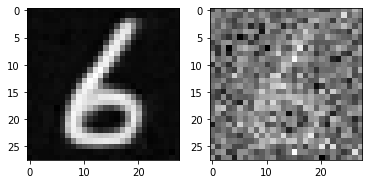

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

saving iteration: 8406 loss: 0.013488
batch loss value:  0.012671348
batch loss value:  0.0127681885
batch loss value:  0.012485616
batch loss value:  0.011979168
saving iteration: 8440 loss: 0.013487
saving iteration: 8444 loss: 0.013439
batch loss value:  0.013498197
batch loss value:  0.011966568
saving iteration: 8462 loss: 0.013431
batch loss value:  0.012736408
batch loss value:  0.013747979
batch loss value:  0.012529053
batch loss value:  0.01206691
iteration: 8500 loss: 0.013881
time step for image:  61  label:  [44]


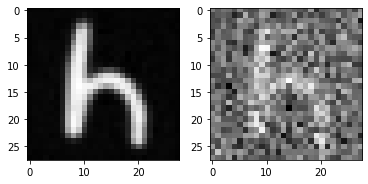

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012137212
batch loss value:  0.013086746
batch loss value:  0.013243371
saving iteration: 8534 loss: 0.013420
saving iteration: 8538 loss: 0.013417
batch loss value:  0.013590223
batch loss value:  0.011606498
saving iteration: 8554 loss: 0.013398
batch loss value:  0.012177024
batch loss value:  0.011855548
batch loss value:  0.013382964
batch loss value:  0.012220843
batch loss value:  0.013741113
iteration: 8600 loss: 0.013636
time step for image:  246  label:  [2]


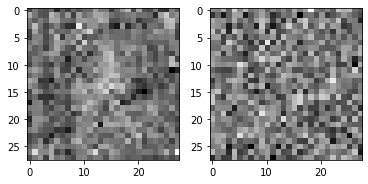

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012756119
batch loss value:  0.01261854
batch loss value:  0.01245402
batch loss value:  0.012410177
batch loss value:  0.013173997
batch loss value:  0.014711737
batch loss value:  0.011574514
batch loss value:  0.013095288
batch loss value:  0.012689572
batch loss value:  0.012128415
iteration: 8700 loss: 0.013743
time step for image:  54  label:  [3]


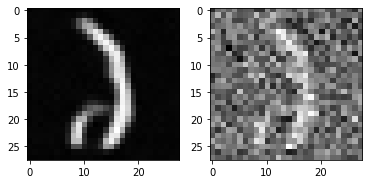

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013751439
batch loss value:  0.0130782705
batch loss value:  0.014158163
batch loss value:  0.01218931
saving iteration: 8740 loss: 0.013352
saving iteration: 8742 loss: 0.013306
batch loss value:  0.012033411
batch loss value:  0.012906259
batch loss value:  0.012748193
batch loss value:  0.012436874
batch loss value:  0.013454987
batch loss value:  0.012937389
iteration: 8800 loss: 0.013518
time step for image:  139  label:  [58]


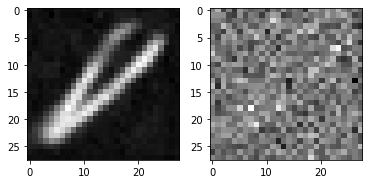

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.011307162
batch loss value:  0.012880362
batch loss value:  0.012629258
batch loss value:  0.012544016
batch loss value:  0.012173084
batch loss value:  0.012205242
batch loss value:  0.012541417
batch loss value:  0.011445189
batch loss value:  0.012204278
batch loss value:  0.012638513
iteration: 8900 loss: 0.013629
time step for image:  135  label:  [2]


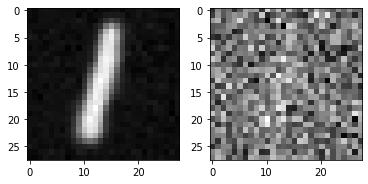

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012391822
batch loss value:  0.012060713
batch loss value:  0.015390006
batch loss value:  0.01253536
batch loss value:  0.012399722
batch loss value:  0.011192327
batch loss value:  0.012671346
batch loss value:  0.011866662
batch loss value:  0.011210882
batch loss value:  0.011764548
iteration: 9000 loss: 0.013699
time step for image:  153  label:  [41]


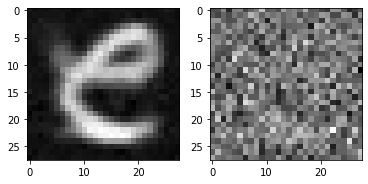

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0127872955
batch loss value:  0.011582982
batch loss value:  0.012072947
batch loss value:  0.012405412
saving iteration: 9042 loss: 0.013261
batch loss value:  0.013012171
batch loss value:  0.012221866
batch loss value:  0.012080175
batch loss value:  0.012125574
batch loss value:  0.011347059
batch loss value:  0.012080371
iteration: 9100 loss: 0.013316
time step for image:  203  label:  [1]


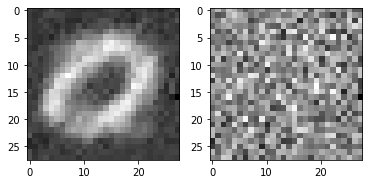

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013705103
batch loss value:  0.012945554
batch loss value:  0.012658193
batch loss value:  0.011765393
batch loss value:  0.013640903
batch loss value:  0.012250053
saving iteration: 9164 loss: 0.013185
batch loss value:  0.0128250085
batch loss value:  0.013188362
batch loss value:  0.013067903
batch loss value:  0.011894191
iteration: 9200 loss: 0.013409
time step for image:  67  label:  [25]


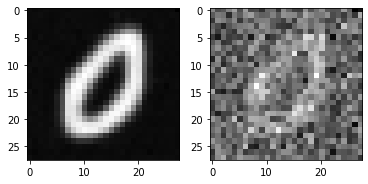

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013728199
batch loss value:  0.012423109
batch loss value:  0.012785703
batch loss value:  0.012501653
batch loss value:  0.012166351
batch loss value:  0.011998884
batch loss value:  0.012513153
batch loss value:  0.012539863
batch loss value:  0.012572667
batch loss value:  0.012789782
iteration: 9300 loss: 0.013390
time step for image:  39  label:  [9]


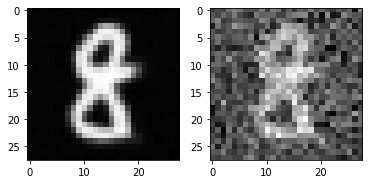

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.011394586
batch loss value:  0.0119957775
batch loss value:  0.011807403
batch loss value:  0.011765212
batch loss value:  0.011839093
batch loss value:  0.012610799
batch loss value:  0.0127659775
batch loss value:  0.012788263
batch loss value:  0.011452876
batch loss value:  0.011043223
iteration: 9400 loss: 0.013337
time step for image:  212  label:  [1]


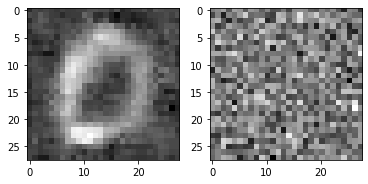

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.011675796
batch loss value:  0.012189978
saving iteration: 9422 loss: 0.013137
batch loss value:  0.011634885
saving iteration: 9432 loss: 0.013130
saving iteration: 9438 loss: 0.013083
batch loss value:  0.011279167
batch loss value:  0.012787366
batch loss value:  0.012595579
batch loss value:  0.013568211
batch loss value:  0.012595631
batch loss value:  0.011855937
saving iteration: 9498 loss: 0.013045
batch loss value:  0.013553793
iteration: 9500 loss: 0.013115
time step for image:  140  label:  [25]


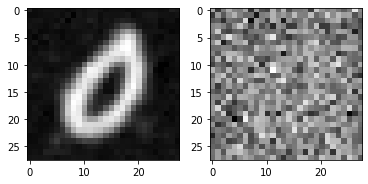

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.01356772
batch loss value:  0.013212278
batch loss value:  0.0126782805
batch loss value:  0.012055864
batch loss value:  0.012881894
batch loss value:  0.0114656305
batch loss value:  0.013549125
batch loss value:  0.01207483
batch loss value:  0.012608824
batch loss value:  0.011441207
iteration: 9600 loss: 0.013243
time step for image:  20  label:  [31]


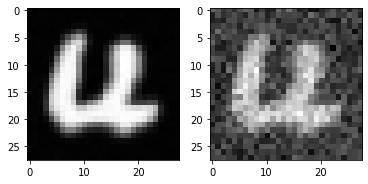

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012057874
batch loss value:  0.013313865
batch loss value:  0.012716033
batch loss value:  0.012277521
batch loss value:  0.012283411
batch loss value:  0.013457933
batch loss value:  0.0123408
batch loss value:  0.013227482
batch loss value:  0.012599077
batch loss value:  0.011815634
iteration: 9700 loss: 0.013078
time step for image:  33  label:  [40]


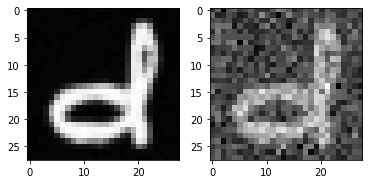

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.012851496
batch loss value:  0.012284864
batch loss value:  0.011937287
batch loss value:  0.013260416
batch loss value:  0.0120936
batch loss value:  0.012886279
batch loss value:  0.011960689
batch loss value:  0.012905594
batch loss value:  0.011421639
batch loss value:  0.012188534
iteration: 9800 loss: 0.013414
time step for image:  225  label:  [2]


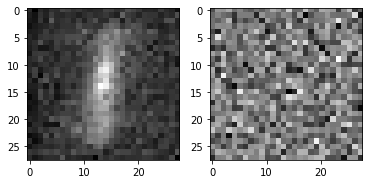

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.013066348
batch loss value:  0.011763143
batch loss value:  0.013103173
batch loss value:  0.012138793
batch loss value:  0.012949155
batch loss value:  0.013086699
batch loss value:  0.011943623
batch loss value:  0.01202205
saving iteration: 9886 loss: 0.012976
batch loss value:  0.0122615555
batch loss value:  0.012312947
iteration: 9900 loss: 0.013211
time step for image:  97  label:  [3]


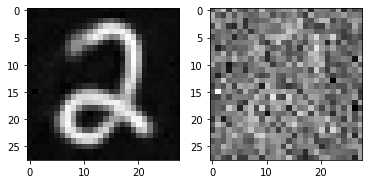

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  0.0118656065
batch loss value:  0.011602864
batch loss value:  0.012882519
batch loss value:  0.011671465
batch loss value:  0.012218669
batch loss value:  0.0129735395
batch loss value:  0.012306607
batch loss value:  0.012475494
batch loss value:  0.011583837


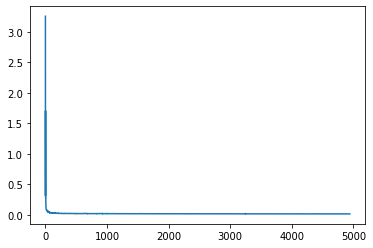

In [28]:
data_noisy, data_in_batch, timestep, losses, avg_params, state = train_model(opt_state, params, avg_params, state, model_name, train_new_model = train_new_model, energy_method=False)
plt.plot(losses)

In [29]:
def param_count(pytree):
  return sum(x.size for x in jax.tree_util.tree_leaves(pytree))

param_count(avg_params)

2233714

## Full generation model

In [30]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [31]:
import random

def generate_data(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, timesteps+1)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy

    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [32]:
batch_size_generation = 64
datas, data_in_batch = generate_data(avg_params, state, label=jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

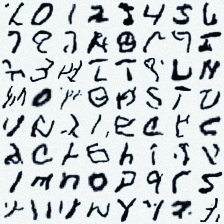

In [33]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

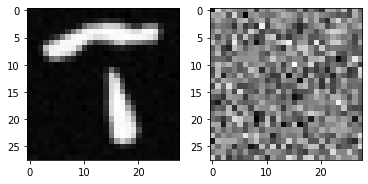

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [34]:
_, (plt1, plt2) = plt.subplots(1, 2)
tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)
# show_image((data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [35]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, timesteps, 10):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full_with_cond.gif', writer='pillow')

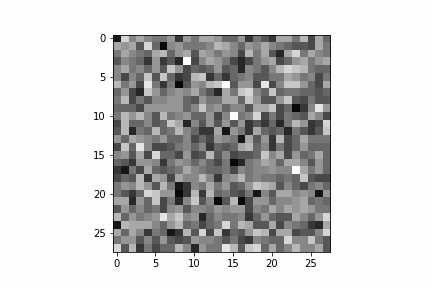

In [36]:
with open(gifs_dir + 'diffusion_generation_full_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [37]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 5)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [38]:
mean_coeff_1_strided = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2_strided = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [39]:
import random

def generate_data_strided(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, len(strided_schedule)+1)
    
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
          
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy                               
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1_strided[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2_strided[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [40]:
batch_size_generation = 64
datas, data_in_batch = generate_data_strided(avg_params, state, label= jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

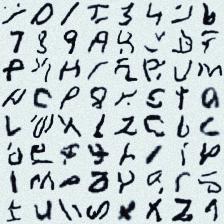

In [41]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

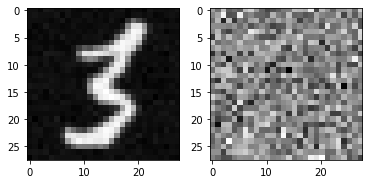

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [42]:
_, (plt1, plt2) = plt.subplots(1, 2)

tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [43]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, len(strided_schedule)):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided_with_cond.gif', writer='pillow')

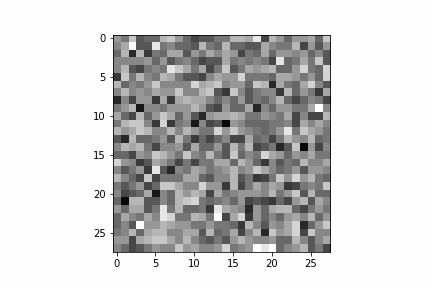

In [44]:
with open(gifs_dir + 'diffusion_generation_strided_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [45]:
import string

x = list(range(1, 63))
y = [str(i) for i in (list(range(0, 10)))] + list(string.ascii_uppercase + string.ascii_lowercase)

dict_ = {}
for i in x:
  dict_[y[i-1]] = i
  
def get_label(ans):
  return jnp.array([dict_[str.upper(char)] for char in ans])

answer = []
answer.append(get_label("varun"))
answer.append(get_label("tulsian"))
answer.append(get_label("2001"))
answer.append(get_label("gmail"))
answer.append(get_label("com"))

In [46]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [47]:
_, d = generate_data(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [48]:
_, d = generate_data(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [49]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [50]:
datas, d = generate_data_strided(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 

rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

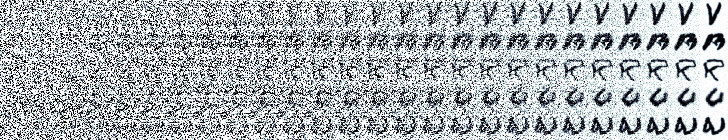

In [51]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=5), cmap='bone_r')

In [52]:
datas, d = generate_data_strided(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 
rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

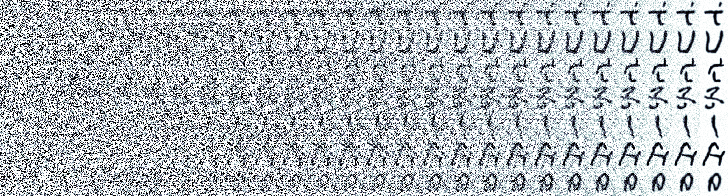

In [53]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=7), cmap='bone_r')

([<matplotlib.lines.Line2D at 0x7f4a08ee1130>],
 [<matplotlib.lines.Line2D at 0x7f4969577bb0>])

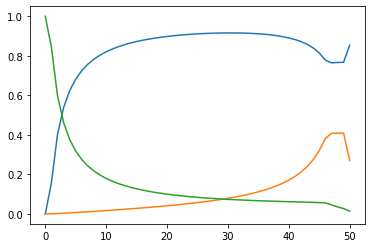

In [54]:
plt.plot(mean_coeff_1_strided), plt.plot(posterior_variance_new_schedule_corrected), plt.plot(mean_coeff_2_strided)

([<matplotlib.lines.Line2D at 0x7f49d0ca9e50>],
 [<matplotlib.lines.Line2D at 0x7f499c540d60>])

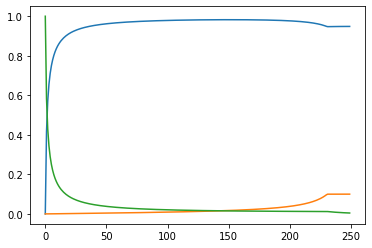

In [55]:
plt.plot(mean_coeff_1), plt.plot(posterior_variance_corrected), plt.plot(mean_coeff_2)